In [224]:
%config Completer.use_jedi = False  # enable code auto-completion
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  #data visualization library
from sklearn.metrics import accuracy_score, confusion_matrix ,precision_score # evaluation metrics

from sklearn.tree import export_text, plot_tree, DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import fetch_openml 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

## Processing The Data Set

In [225]:
## read the data set
df = pd.read_csv("breast-cancer.csv")

## drop id
df.drop(columns = ['id'] , inplace = True )

## transform diagnosis into binary value
df.replace({'diagnosis': {'B': 0, 'M': 1}}, inplace=True)
diagnosis = df['diagnosis']
## We use StandardScaler to transform the feature
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

#set diagnosis back to binary
df['diagnosis'] = diagnosis
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,...,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,...,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,1,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,...,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,1,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,...,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,1,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,...,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100


## Visualize the correlation between features and label:


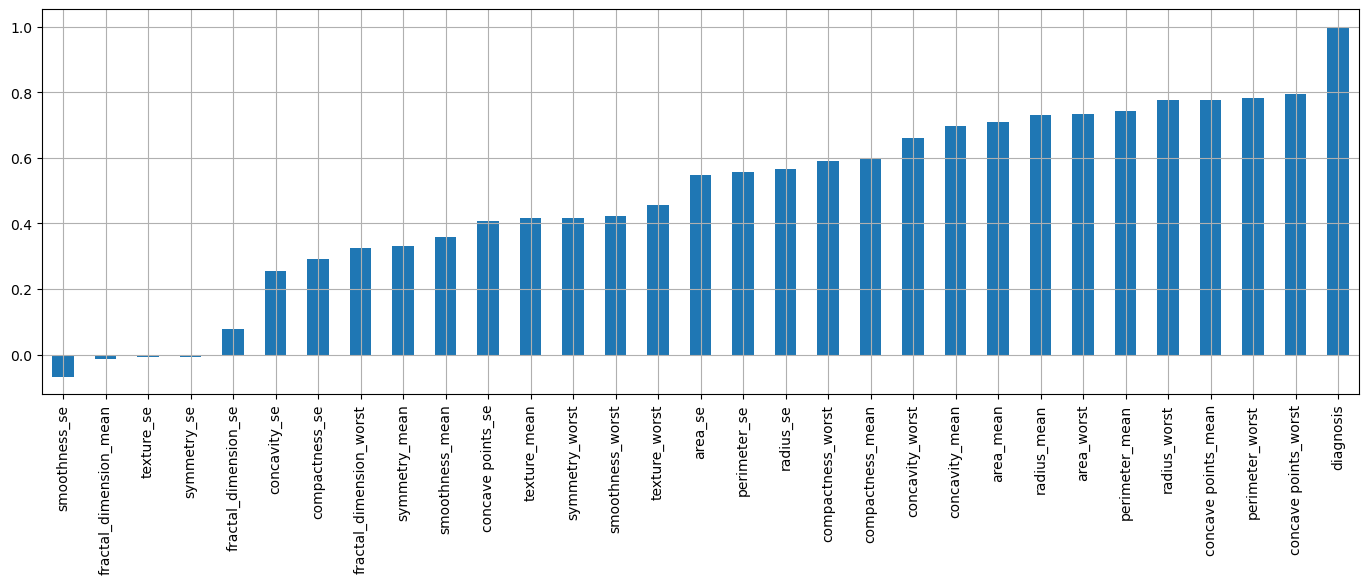

In [226]:
plt.figure(figsize=(17,5))
df.corr()["diagnosis"].sort_values(ascending=True).plot(kind="bar")
plt.grid()
plt.show()


## Visualize the correlation betweens features with heat map:

<Axes: >

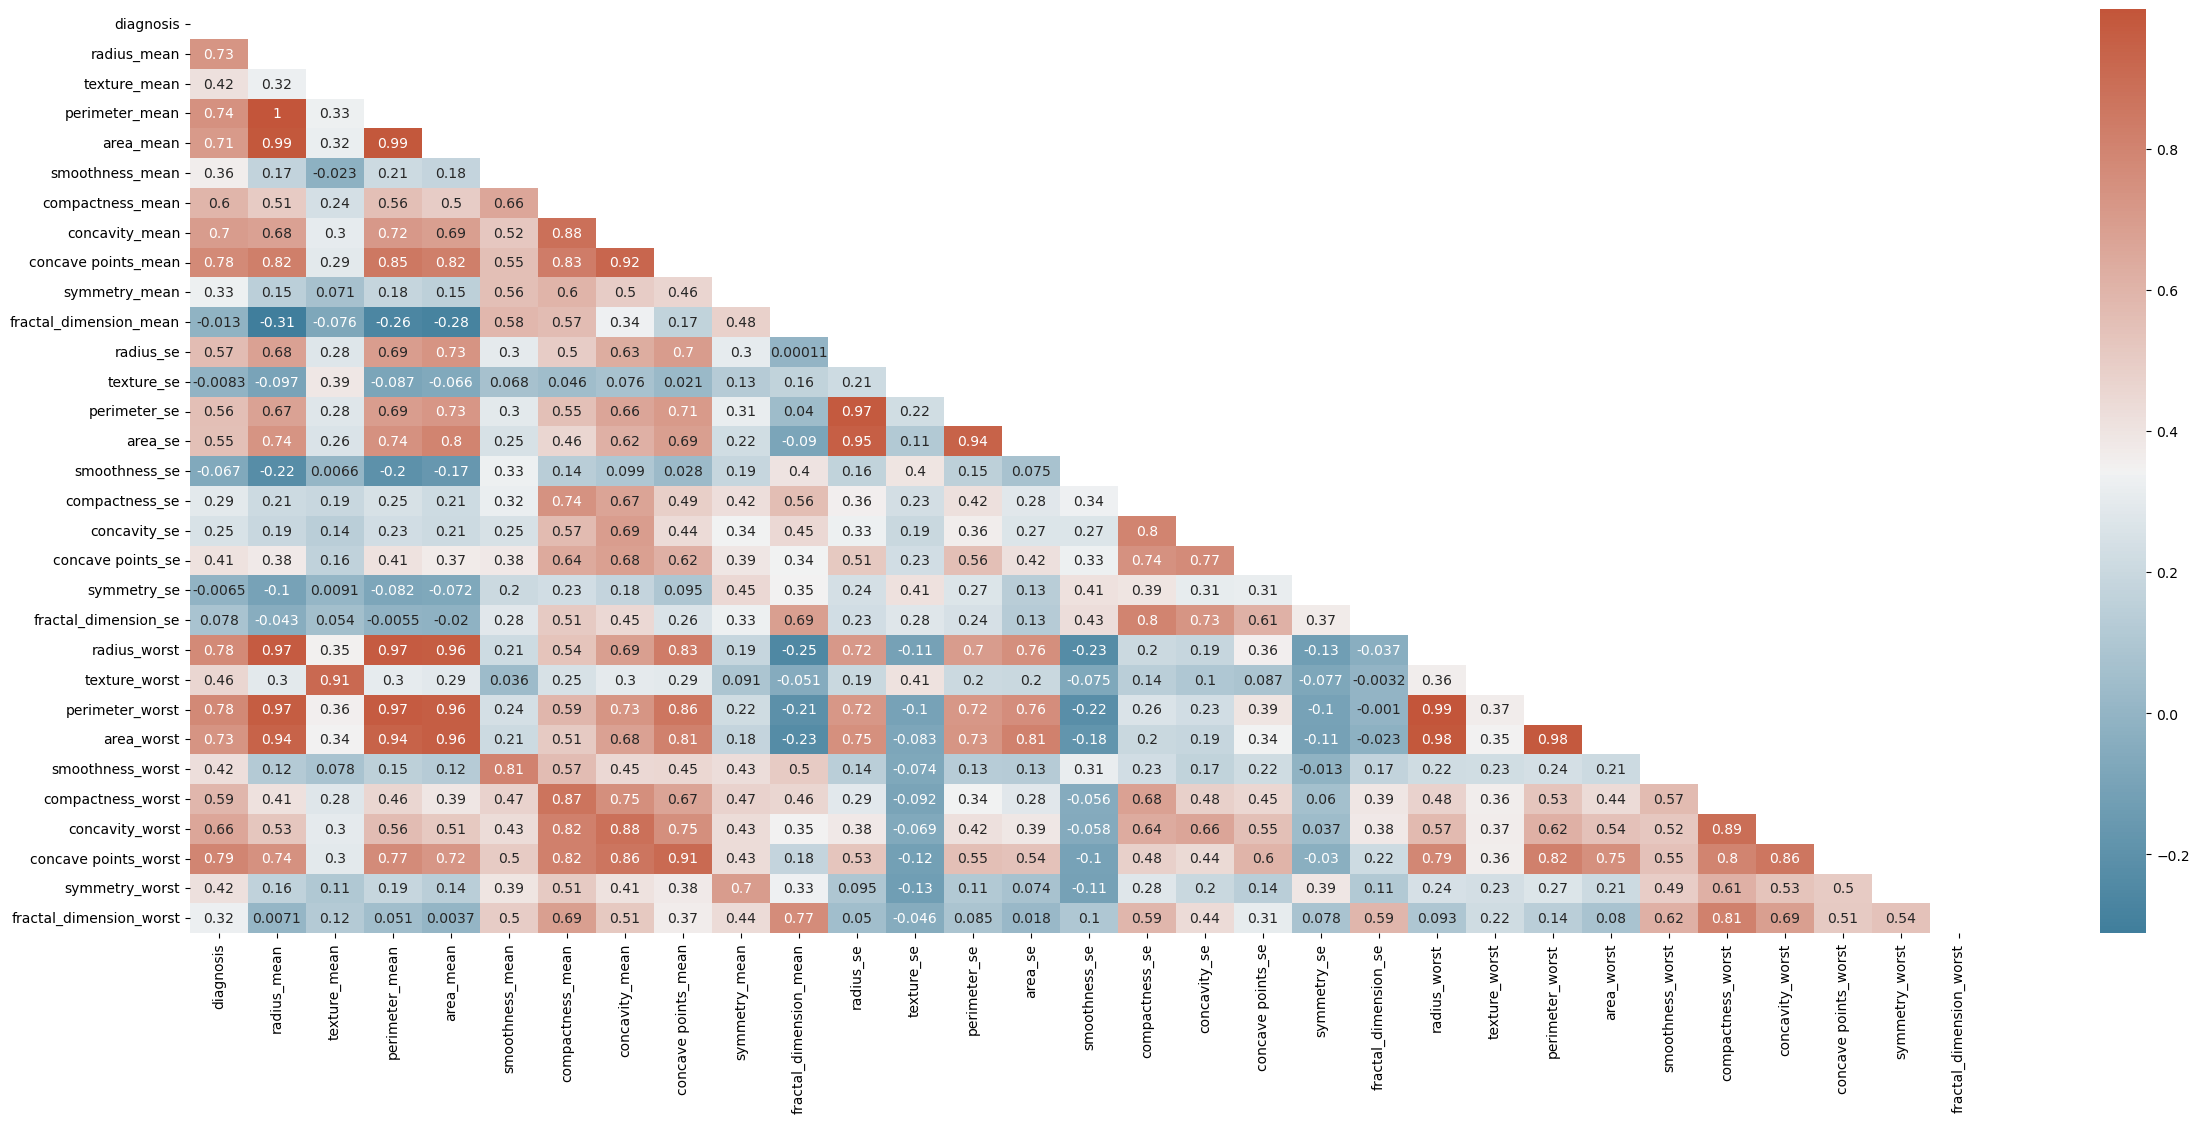

In [227]:
corr = df.corr()
f, ax = plt.subplots(figsize=(29, 12))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

## Feature engineering with PCA: 
we start by plotting Cumulative and Explained variance ratio with number of generated feature. 


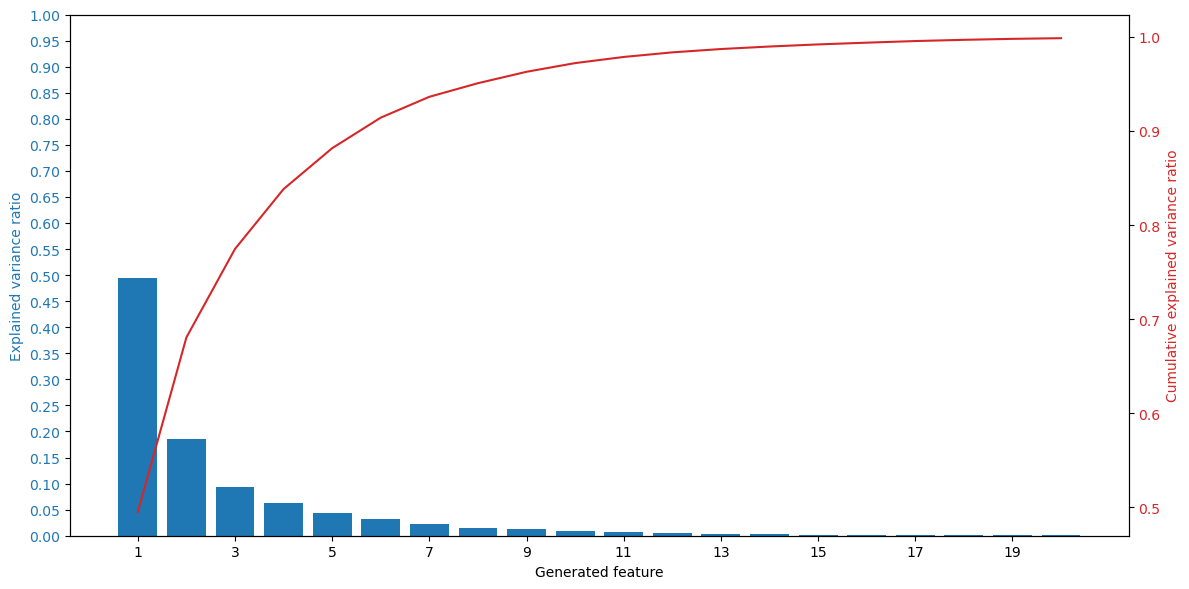

In [228]:

x = df.drop(columns = ['diagnosis','symmetry_se','fractal_dimension_mean','texture_se','smoothness_se'] )
y = df['diagnosis']
X_train_val, X_test, y_train_val, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

N = 20
pca = PCA(n_components=N)
X_train_reduced = pca.fit_transform(X_train_val)

fig, ax1 = plt.subplots(figsize=(12, 6))
color = 'tab:blue'
ax1.bar(1+np.arange(N), pca.explained_variance_ratio_, color=color)
ax1.set_xticks(1+np.arange(N, step=2))
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel("Explained variance ratio", color=color)
ax1.set_xlabel("Generated feature")

ax1.set_yticks(np.arange(0, 1.05, 0.05))
ax2 = ax1.twinx()
color = 'tab:red'
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(1+np.arange(N), np.cumsum(pca.explained_variance_ratio_), color=color)
ax2.set_ylabel("Cumulative explained variance ratio", color=color)
fig.tight_layout()
plt.show()

<Axes: >

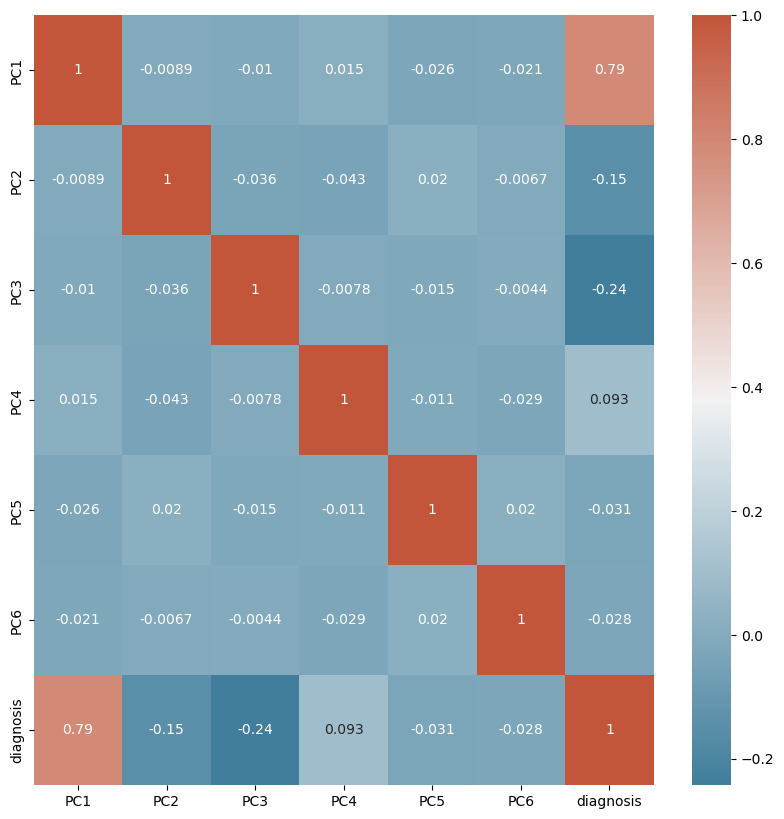

In [229]:
N = 6
pca.set_params(n_components = N)
X_train_reduced = pca.fit_transform(X_train_val)


newdf = pd.DataFrame(pca.transform(x), columns=[f'PC{i}' for i in range(1, N+1)])
newdf['diagnosis'] = y
corr = newdf.corr()
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=True,  cmap=cmap)



In [230]:
##Define k fold
k = 5

seed = 3

kfold = KFold(n_splits=k, shuffle=True, random_state=seed)




In [234]:
# Initialize variables
average_train_precision_tree_pca = 0
average_train_accuracy_tree_pca = 0
average_val_precision_tree_pca = 0
average_val_accuracy_tree_pca = 0

average_train_precision_Logistic_pca = 0
average_train_accuracy_Logistic_pca = 0
average_val_precision_Logistic_pca = 0
average_val_accuracy_Logistic_pca = 0

# Loop through all folds
for train_index, val_index in kfold.split(y_train_val):
    X_train, y_train = X_train_reduced[train_index], y_train_val.iloc[train_index]
    X_val, y_val = X_train_reduced[val_index], y_train_val.iloc[val_index]

    # Decision Tree Classifier
    clf_1 = DecisionTreeClassifier(criterion="entropy", max_depth=5, random_state=42)
    clf_1.fit(X_train, y_train)
    y_pred_val_1 = clf_1.predict(X_val)

    average_train_accuracy_tree_pca += accuracy_score(y_train, clf_1.predict(X_train))
    average_train_precision_tree_pca += precision_score(y_train, clf_1.predict(X_train))

    average_val_precision_tree_pca += precision_score(y_val, y_pred_val_1)
    average_val_accuracy_tree_pca += accuracy_score(y_val, y_pred_val_1)

    # Logistic Regression
    clf_2 = LogisticRegression()
    clf_2.fit(X_train, y_train)
    y_pred_val_2 = clf_2.predict(X_val)

    average_train_accuracy_Logistic_pca += accuracy_score(y_train, clf_2.predict(X_train))
    average_train_precision_Logistic_pca += precision_score(y_train, clf_2.predict(X_train))

    average_val_precision_Logistic_pca += precision_score(y_val, y_pred_val_2)
    average_val_accuracy_Logistic_pca += accuracy_score(y_val, y_pred_val_2)

# Calculate and print results
print("Decision Tree Classifier with PCA:")
print("Average Training Accuracy:", average_train_accuracy_tree_pca / k)
print("Average Training Precision:", average_train_precision_tree_pca / k)
print("Average Validation Accuracy:", average_val_accuracy_tree_pca / k)
print("Average Validation Precision:", average_val_precision_tree_pca / k)

y_pred_test_tree = clf_1.predict(pca.transform(X_test))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test_tree))
print("Test Precision:", precision_score(y_test, y_pred_test_tree))
print()

print("Logistic Regression with PCA:")
print("Average Training Accuracy:", average_train_accuracy_Logistic_pca / k)
print("Average Training Precision:", average_train_precision_Logistic_pca / k)
print("Average Validation Accuracy:", average_val_accuracy_Logistic_pca / k)
print("Average Validation Precision:", average_val_precision_Logistic_pca / k)

y_pred_test_log = clf_2.predict(pca.transform(X_test))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test_log))
print("Test Precision:", precision_score(y_test, y_pred_test_log))


Decision Tree Classifier with PCA:
Average Training Accuracy: 0.9934065934065934
Average Training Precision: 0.992514869262709
Average Validation Accuracy: 0.9384615384615385
Average Validation Precision: 0.9237593984962407
Test Accuracy: 0.9122807017543859
Test Precision: 0.8837209302325582

Logistic Regression with PCA:
Average Training Accuracy: 0.976923076923077
Average Training Precision: 0.9733397570290243
Average Validation Accuracy: 0.9626373626373625
Average Validation Precision: 0.9482721956406166
Test Accuracy: 0.9824561403508771
Test Precision: 0.9767441860465116


In [236]:
# Initialize variables
average_train_precision_tree = 0
average_train_accuracy_tree = 0
average_val_precision_tree = 0
average_val_accuracy_tree = 0

average_train_precision_Logistic = 0
average_train_accuracy_Logistic = 0
average_val_precision_Logistic = 0
average_val_accuracy_Logistic = 0

# Loop through all folds
for train_index, val_index in kfold.split(y_train_val):
    X_train, y_train = X_train_val.iloc[train_index], y_train_val.iloc[train_index]
    X_val, y_val = X_train_val.iloc[val_index], y_train_val.iloc[val_index]

    # Decision Tree Classifier
    clf_1 = DecisionTreeClassifier(criterion="entropy", max_depth=5, random_state=42)
    clf_1.fit(X_train, y_train)
    y_pred_1 = clf_1.predict(X_val)

    average_val_precision_tree += precision_score(y_val, y_pred_1)
    average_val_accuracy_tree += accuracy_score(y_val, y_pred_1)

    average_train_accuracy_tree += accuracy_score(y_train, clf_1.predict(X_train))
    average_train_precision_tree += precision_score(y_train, clf_1.predict(X_train))

    # Logistic Regression
    clf_2 = LogisticRegression(max_iter=5000, penalty='l1', solver='saga')
    clf_2.fit(X_train, y_train)
    y_pred_2 = clf_2.predict(X_val)

    average_train_accuracy_Logistic += accuracy_score(y_train, clf_2.predict(X_train))
    average_train_precision_Logistic += precision_score(y_train, clf_2.predict(X_train))

    average_val_precision_Logistic += precision_score(y_val, y_pred_2)
    average_val_accuracy_Logistic += accuracy_score(y_val, y_pred_2)

# Calculate and print results
print("Decision Tree Classifier without PCA:")
print("Average Training Accuracy:", average_train_accuracy_tree / k)
print("Average Training Precision:", average_train_precision_tree / k)
print("Average Validation Accuracy:", average_val_accuracy_tree / k)
print("Average Validation Precision:", average_val_precision_tree / k)

y_pred_test_tree = clf_1.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred_test_tree))
print("Test Precision:", precision_score(y_test, y_pred_test_tree))

print()

print("Logistic Regression without PCA:")
print("Average Training Accuracy:", average_train_accuracy_Logistic / k)
print("Average Training Precision:", average_train_precision_Logistic / k)
print("Average Validation Accuracy:", average_val_accuracy_Logistic / k)
print("Average Validation Precision:", average_val_precision_Logistic / k)

y_pred_test_log = clf_2.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred_test_log))
print("Test Precision:", precision_score(y_test, y_pred_test_log))



Decision Tree Classifier without PCA:
Average Training Accuracy: 0.9972527472527473
Average Training Precision: 1.0
Average Validation Accuracy: 0.9252747252747253
Average Validation Precision: 0.9020448726900341
Test Accuracy: 0.9385964912280702
Test Precision: 0.9090909090909091

Logistic Regression without PCA:
Average Training Accuracy: 0.9846153846153847
Average Training Precision: 0.9852719721146741
Average Validation Accuracy: 0.9670329670329672
Average Validation Precision: 0.9759868421052632
Test Accuracy: 0.9736842105263158
Test Precision: 0.9545454545454546


Text(0.5, 23.52222222222222, 'Predicted Label')

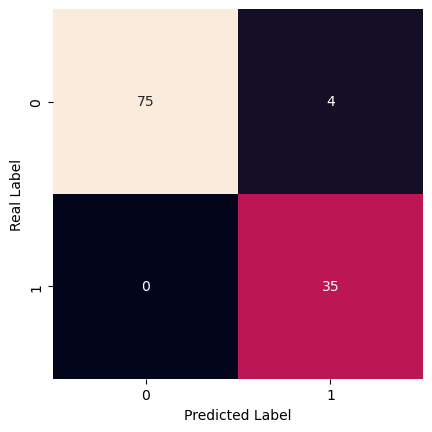